In [12]:
#import stuff
import pandas as pd
import numpy as np
import seaborn as s
from matplotlib import pyplot as plt
import numpy.linalg as la
import lib as l
import copy
import tqdm
from sklearn.metrics import confusion_matrix as cm

In [66]:
#import data
pokemon = pd.read_csv('data/pokemon.csv', header = None, 
                     skiprows=1, encoding = 'latin-1', low_memory = False,
                    names = ['Name', 'Version', 'Primary Type' ,'Secondary Type', 'Stage' ,'Attack', 'Defense' , 'HP', 'Sp. Attack', 'Sp. Defense', 'Speed', 'Total', 'Legendary']
)
noMega = pokemon[pokemon['Version'].isnull()] # for KNN alg

img = plt.imread("logo.png") # get the pokemon logo :)

# Question 1;

This is the data set of all current pokemon as of 11/23/21. This represents a statistical outlook of the 1045 pokemon. This includes legendaries, mythical, and mega evolution variants. Their attributes are broken down into 7 numerical categories. They represents how strong the corresponding attribute of the pokemon is. So the higher the value, the stronger the attribute will be. The categories are as follows:

    - HP
    - Attack
    - Defense
    - Special Attack
    - Special Defense
    - Speed
    - Total
    
These are not the actual values of the attributes. _i.e._ If I have a Lvl 100 Venusaur, I won't have 82 Attack. It is more like a scale that determines the boundaries that a pokemon's attributes are tied to. 

# Question 2;

There are few, not so obvious **classes** that are present in this data set. One of which can be determining if a pokemon is considered _Statistically Strong_. This has a vague definition, but generally the higher the pokemon's attributes are, the better they can do in battle. For our purpose, we will define statistically strong as _having a higher total than 500, as well as having at least 3 of their 6 attributes being in the third quartile of all values._ This will hopefully eliminate any outliers or pokemon that have all their power in a few stats. **(Blissey)**

Another class is whether the pokemon have a secondary type or not. There really is no correlation with the data we currently have, but if we added a column that gave us the evolution stage that a pokemon is in, (1, 2, or 3), we could define secondary types with evolution stage as a potential class. 

## Important Statistics & Info of the Set:

1. We will be excluding ALL mega evolution forms of pokemon as well as **Eternamax** for our KNN alg because they will cause some annoying skewing.

2. For our K-means clustering algorithm, we will be including all 1045 pokemon. This will prove our point later on that K-means is NOT a good algorithm to use on this data set.

We will provide some basic stats about our set below:

In [4]:
stats = noMega.describe().round(3)
stats

,Stage,Attack,Defense,HP,Sp. Attack,Sp. Defense,Speed,Total
count,870.000,870.000,870.000,870.000,870.000,870.000,870.000,870.000
mean,1.614,76.017,71.511,68.706,69.117,69.387,65.143,419.882
std,0.704,29.471,29.533,26.272,29.061,26.859,28.110,110.641
min,1.000,5.000,5.000,1.000,10.000,20.000,5.000,180.000
25%,1.000,55.000,50.000,50.000,45.000,50.000,45.000,320.000
50%,1.000,75.000,67.000,65.000,65.000,65.000,64.000,430.000
75%,2.000,95.000,90.000,80.000,90.000,85.000,85.000,500.000
max,3.000,181.000,230.000,255.000,173.000,230.000,200.000,720.000


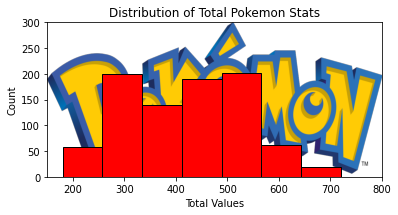

In [5]:
#distribution of total values (no mega or eternamax)
noMega['Total'].hist(color = 'red', ec = 'black', grid = False, bins = 7)
plt.title("Distribution of Total Pokemon Stats")
plt.xlabel("Total Values")
plt.ylabel("Count")
plt.imshow(img, extent = [150, 800, 0, 300])

# K-nearest Neighbors Algorithm

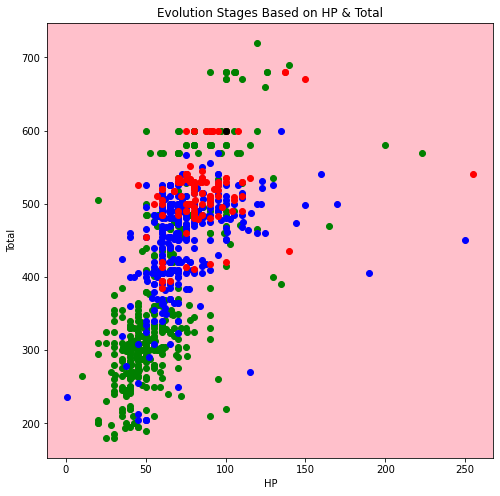

In [80]:
# SPLIT INTO OUR THREE STAGES 
stage_one = noMega[noMega['Stage'] == 1]
stage_two = noMega[noMega['Stage'] == 2]
stage_three = noMega[noMega['Stage'] == 3]

#make random pokemon
random_pokemon = [100, 600]

#PLOTTING
plt.scatter(x = stage_one['HP'], y = stage_one['Total'], color = 'g')
plt.scatter(x = stage_two['HP'], y = stage_two['Total'], color = 'b')
plt.scatter(x = stage_three['HP'], y = stage_three['Total'], color = 'r')
plt.scatter(x = random_pokemon[0], y = random_pokemon[1], color = 'black')
plt.title("Evolution Stages Based on HP & Total")
plt.xlabel("HP")
plt.ylabel("Total")
plt.gca().set_facecolor('pink')
plt.gcf().set_size_inches(8,8)

In [81]:
#Predicting what stage a pokemon is based off of HP and Total
knn = l.KNN(3)

knn_set = noMega[['HP', 'Total']].to_numpy()
labels = noMega['Stage'].values 

knn.train(knn_set, labels)

#predict random pokemon from above
pred = knn.predict(random_pokemon)
print(f'The predicted stage of {random_pokemon} is ~> Stage {pred.most_common(1)[0][0]}')

The predicted stage of [100, 600] is ~> Stage 1


In [99]:
# test to see how this alg performs on large sums of data
def divideSets(p,data):
    copydata = copy.deepcopy(data)
    np.random.shuffle(copydata)
    list1 = copydata[:int(p*len(copydata))]
    list2 = copydata[int(p*len(copydata)):]
    return (list1,list2)


stages = noMega[['Total', 'Stage']].to_numpy()

p = 0.6
n = len(noMega['Total'])
rets = divideSets(p, stages)
list1 = rets[0]
list2 = rets[1]

data1 = [t[0] for t in list1]
label1 = [t[1] for t in list1]

data2 = [t[0] for t in list2]
label2 = [t[1] for t in list2]


In [100]:
k = 3
knn = l.KNN(k)

knn.train(data1,label1)

prediction = []
for x in data2:
    prediction.append(knn.predict(x))
    
predictions = [prediction[i].most_common(2)[0][0] for i in range(len(prediction))]
#print(predictions)


## Issues with this Algorithm
The problem lies with the **legendary** pokemon.

Majority of them don't have an evolution path, so they are all considered stage 1. Therefore, it severely skews the data. Thus being difficult to predict pokemon with higher stats.

Below we can see the means for each stage.

In [101]:
new = noMega[['Total' , 'Stage']]

one = new[new['Stage'] == 1]
two = new[new['Stage'] == 2]
three = new[new['Stage'] == 3]

print(one['Total'].mean())
print(two['Total'].mean())
print(three['Total'].mean())

377.36160714285717
446.9516129032258
515.0357142857143


In [102]:
#print('True Evolution Stages \n', label2)
#print('\n Predicted Evolution Stages \n', predictions)
print('Confusion Matrix: \n', cm(label2,predictions))
print('\n Normalized Confusion Matrix: \n', cm(label2,predictions, normalize = 'true'))

Confusion Matrix: 
 [[157  21  16]
 [ 27  69  17]
 [ 12   7  22]]

 Normalized Confusion Matrix: 
 [[0.80927835 0.10824742 0.08247423]
 [0.23893805 0.61061947 0.15044248]
 [0.29268293 0.17073171 0.53658537]]


Note that **Stage 1** has a fairly high total mean, and the confusion matrix is not fantastic, considering they are the *weak* pokemon. The legendaries very much skew the set to have a larger mean than intended. $ \\ $ This is where the __No Legendaries__ set comes into play.

In [92]:
# no legendaries section
noLeg = noMega[noMega['Legendary'] == 'N'] # for KNN alg


one = noLeg[noLeg['Stage'] == 1]
two = noLeg[noLeg['Stage'] == 2]
three = noLeg[noLeg['Stage'] == 3]

oneM = one['Total'].mean()
twoM = two['Total'].mean()
threeM = three['Total'].mean()

print(f'Stage 1 mean ~> {oneM}\nStage 2 mean ~> {twoM}\nStage 3 mean ~> {threeM}')


Stage 1 mean ~> 336.344
Stage 2 mean ~> 445.89869281045753
Stage 3 mean ~> 512.0363636363636


As you can see, the mean for stage 1 dropped by over 10%. This should allow for a much more accurate prediction, and the scatterplot of the new data points is:

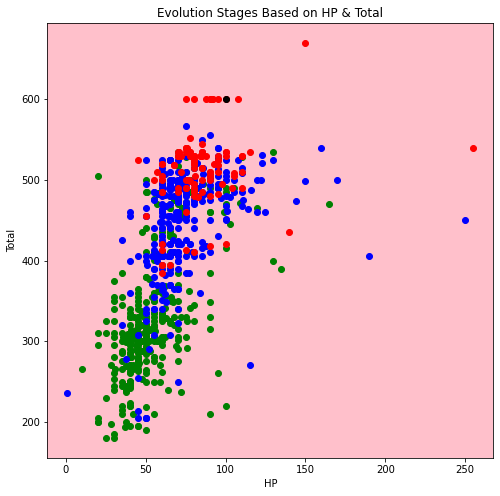

In [82]:
# SPLIT INTO OUR THREE STAGES 
stage_one = noLeg[noLeg['Stage'] == 1]
stage_two = noLeg[noLeg['Stage'] == 2]
stage_three = noLeg[noLeg['Stage'] == 3]

#make random pokemon
random_pokemon = [100, 600]

#PLOTTING
plt.scatter(x = stage_one['HP'], y = stage_one['Total'], color = 'g')
plt.scatter(x = stage_two['HP'], y = stage_two['Total'], color = 'b')
plt.scatter(x = stage_three['HP'], y = stage_three['Total'], color = 'r')
plt.scatter(x = random_pokemon[0], y = random_pokemon[1], color = 'black')
plt.title("Evolution Stages Based on HP & Total")
plt.xlabel("HP")
plt.ylabel("Total")
plt.gca().set_facecolor('pink')
plt.gcf().set_size_inches(8,8)

In [83]:
#Predicting what stage a pokemon is based off of HP and Total
knn = l.KNN(3)

knn_set = noLeg[['HP', 'Total']].to_numpy()
labels = noLeg['Stage'].values 

knn.train(knn_set, labels)

#predict random pokemon from above
pred = knn.predict(random_pokemon)
print(f'The predicted stage of {random_pokemon} is ~> Stage {pred.most_common(1)[0][0]}')

The predicted stage of [100, 600] is ~> Stage 3


In [96]:
stages = noLeg[['Total', 'Stage']].to_numpy()

p = 0.6
n = len(noLeg['Total'])
rets = divideSets(p, stages)
list1 = rets[0]
list2 = rets[1]

data1 = [t[0] for t in list1]
label1 = [t[1] for t in list1]

data2 = [t[0] for t in list2]
label2 = [t[1] for t in list2]



# creating a confusion matrix
k = 3
knn = l.KNN(k)

knn.train(data1,label1)

prediction = []
for x in data2:
    prediction.append(knn.predict(x))
    
predictions = [prediction[i].most_common(2)[0][0] for i in range(len(prediction))]
#print(predictions)
#print('True Evolution Stages \n', label2)
#print('\n Predicted Evolution Stages \n', predictions)
print('Confusion Matrix: \n', cm(label2,predictions))
print('\n Normalized Confusion Matrix: \n', cm(label2,predictions, normalize = 'true'))

Confusion Matrix: 
 [[134  19   5]
 [ 27  75  14]
 [  4   8  31]]

 Normalized Confusion Matrix: 
 [[0.84810127 0.12025316 0.03164557]
 [0.23275862 0.64655172 0.12068966]
 [0.09302326 0.18604651 0.72093023]]


As you can see, the algorithm is much better at predicting **Stage 2 and 3** pokemon due to the lack of legendaries. It also has a better idea of what **Stage 1** are _supposed_ to look like, notice the % of **Stage 1** pokemon that are predicted as **Stage 3** DRASTICALLY decreases. 

# K-means Clustering

In [25]:
kMeans_set = pokemon[['Attack', 'Defense']].values
kMeans_set

array([[ 49,  49],
       [ 62,  63],
       [ 82,  83],
       ...,
       [ 80,  80],
       [165, 150],
       [ 85,  80]])

In [26]:
class KMeansClassifier:
    """Given some data, determines k means to be used for classification"""
    def __init__(self):
        self.means = []
    
    def train(self, data, k):
        """Run the k-means algorithm, stores the final means in self.means"""
        
        # so we can be destructive
        copy_data = np.copy(data)
        
        # 1. choose k points at random from data
        
        # not necessary if data is all numeric
        # copy_data = copy.deepcopy(data)
        
        np.random.shuffle(copy_data)
        self.means = copy_data[:k] # grab the first k rows after a random shuff
        
        # 2. loop the following until self.means stops changing
        #    - for each self.means as m, gather all rows of copy_data
        #         for which m is the closest mean, call this group_m
        print(f'Before Training:\n{self.means}')        
        count = 0
        while count < 10: # want to add a convergence check
            for i in range(len(self.means)):
                group = [0,0] # set of rows in copy_data for which self.means[i] is the closest mean
                           # aggregated group as a matrix, rows are rows of data
                for row in copy_data:
                    num_times = 0
                    distances = []
                    for j in range(len(self.means)):
                        # calculate distance to self.means[i]
                        distances.append(la.norm(row - self.means[j]))
                    # if min distance is at index i, then np.vstack([ group, row ])
                    min0 = np.array(distances)
                    min0 = min0.argsort()
                    if min0[0] == i:
                        group = np.vstack([group, row])
                
                # get rid of first row, which is 0,0 to make vstack work
                group = group[1:]
                self.means[i] = np.mean(group, axis=0)
        #    - re-assign self.means[m] = mean(group_m)
            count += 1
            #print(self.means) #to test
        print(f'After Training:\n{self.means}')
    
    
    def test(self, x):
        """Return the mean closest to x among self.means"""
        # find row of self.means that is the closest to x in euclidean distance
        # return it
        for i in range(len(self.means)):
            distance = []
            for j in range(len(self.means)):
                # calculate distance to self.means[i]
                distance.append(la.norm(x - self.means[j]))
            # if min distance is at index i, then np.vstack([ group, row ])
            min0 = np.array(distance)
            min0 = min0.argsort()
            if min0[0] == i:
                return min0[0]
        # to see if something screwed up
        print("Error :(")
        return -1

In [27]:
means = KMeansClassifier()
means.train(kMeans_set, 3)

Before Training:
[[45 45]
 [30 30]
 [50 45]]
After Training:
[[ 76  74]
 [ 46  44]
 [118 103]]


In [28]:
point = [75,75]
print(f'Mean that {point} is closest to ~> {means.test(point)}')

Mean that [75, 75] is closest to ~> 0
